# <font color='violet'> Complete Feature Engineering. Assign Ratings to Psychedelic Experience Reports & Analyze Findings
    
Drawing from scraped psychedelic experience reports that were cleaned here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/9-kl-reports-clean-engineer.ipynb

In [1]:
import pandas as pd
from textblob import TextBlob
import spacy
import pickle
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

In [2]:
# prepare to add local python functions; import modules from src directory
import sys
src = '../src'
sys.path.append(src)

# import local functions
from nlp.feature_engineer import analyze_sentiment

In [3]:
# Import data
df = pd.read_csv('../data/processed/erowid_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4562 entries, 0 to 4561
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     4562 non-null   int64  
 1   drug           4562 non-null   object 
 2   weight         4562 non-null   object 
 3   year           4562 non-null   object 
 4   gender         4562 non-null   object 
 5   age            4562 non-null   object 
 6   report         4562 non-null   object 
 7   complexity     4562 non-null   float64
 8   no_stops_lemm  4562 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 320.9+ KB


In [4]:
# Delete irrelevant columns
df = df.drop(columns=['Unnamed: 0', 'weight', 'gender'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4562 entries, 0 to 4561
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   drug           4562 non-null   object 
 1   year           4562 non-null   object 
 2   age            4562 non-null   object 
 3   report         4562 non-null   object 
 4   complexity     4562 non-null   float64
 5   no_stops_lemm  4562 non-null   object 
dtypes: float64(1), object(5)
memory usage: 214.0+ KB


<font color='violet'> Add additional columns that were part of the original model

In [5]:
# Analyze sentiment
analyze_sentiment(df, 'report')
df.head(3)

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442


In [6]:
# Measure the length of each review
df['review_len'] = [len(df.loc[row,'report']) for row in range(len(df))]
df.head(3)

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329


In [7]:
# Find similarity w/ the 10-rated meta-review from the original studies

# Get the original text to find similarity with
with open('../data/processed/rating_10_meta.txt', 'r') as file:
    rating_10_meta = file.read()

# Instantiate the spacy model
nlp = spacy.load('en_core_web_lg') 

# Turn the sting into a spacy doc
rating_10_meta = nlp(rating_10_meta)

# Create column
df['similarity_w_10'] = df.no_stops_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_10_meta))

df.head(3)

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947,0.892374
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718,0.970629
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329,0.964469


<font color='violet'> Prepare data & make predictions with pre-trained model to assign ratings.

In [8]:
# Rename the lemmatized text column to 'review' and 'polarity' to 'original_polarity'
X_unseen = df.rename(columns={'no_stops_lemm':'review', 'polarity':'original_polarity'})

# Isolate just rows used in the original model:
X_unseen = X_unseen[['review', 'review_len', 'complexity', 'subjectivity', 'original_polarity', 
                'similarity_w_10']]

X_unseen.head()

,review,review_len,complexity,subjectivity,original_polarity,similarity_w_10
0,see buddhanature dmt 22 year old male 102 ...,5947,7.9,0.386781,0.101679,0.892374
1,past week chance try aet 3 different dosage ...,9718,7.8,0.485326,0.104717,0.970629
2,800 pm \t 130 mg aet oral capsule t+315 \...,11329,7.2,0.536657,0.149442,0.964469
3,read people insuffulate bring quick burn eye...,1079,5.6,0.532292,0.207292,0.911463
4,mid late 80 aet legal available usual chemic...,1698,6.9,0.447603,0.140524,0.956280


In [9]:
# load pickled trained classifier with which to assign ratings
with open("../models/trained_model.pkl", "rb") as f:
    model = pickle.load(f)

# Assign ratings
ratings = model.predict(X_unseen)
ratings

array([4, 4, 4, ..., 4, 4, 4])

In [10]:
# Rejoin ratings to the original dataframe. 
df['rating'] = ratings
df.head()

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10,rating
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947,0.892374,4
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718,0.970629,4
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329,0.964469,4
3,AET,2007,Not Given,i read about people insuffulating this to bri...,5.6,read people insuffulate bring quick burn eye...,0.532292,0.207292,1079,0.911463,4
4,AET,1986,Not Given,back in the mid to late 80s aet was legal and...,6.9,mid late 80 aet legal available usual chemic...,0.447603,0.140524,1698,0.956280,4


In [11]:
set(ratings)

{3, 4}

Every text was given a rating of 3 or 4. 

<font color='violet'> Initial Analysis
    
Here's what I noted about the model from when I first trained it:
- When the model predicted a score of 4, it's correct 73% of the time. It's within one point 89% of the time. 11% of the time, the rating should actually have been 1-3.
- When the model predicts a score of 3, it's correct 34% of the time. It's within one point 82% of the time. 18% of the time, the score should have been a 0-1
    
More specifically: 
I could add a column that takes into consideration this margin of error. From all rows that have a predicted rating of 4, re-assign 16% to have a rating of 3, 4% to have a rating of 2, 2% to have a rating of 1 and 5% to have a rating of 0. From all rows that have a predicted rating of 3, reassign 36% to have a rating of 4, 12% a rating of 2, 8% a rating of 1, and 10% a rating of 0. Do this reassignment randomly across the dataset. 

In [12]:
four_reassignment = [4]*73 + [3]*16 + [2]*4 + [1]*2 + [0]*5
three_reassignment = [4]*36 + [3]*34 + [2]*12 + [1]*8 + [0]*10

for row in range(len(df)):
    if df.loc[row,'rating'] == 4:
        df.loc[row,'adjusted_rating'] = random.choices(four_reassignment)
    else: df.loc[row,'adjusted_rating'] = random.choices(three_reassignment)

df.head()

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10,rating,adjusted_rating
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947,0.892374,4,4.0
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718,0.970629,4,2.0
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329,0.964469,4,4.0
3,AET,2007,Not Given,i read about people insuffulating this to bri...,5.6,read people insuffulate bring quick burn eye...,0.532292,0.207292,1079,0.911463,4,4.0
4,AET,1986,Not Given,back in the mid to late 80s aet was legal and...,6.9,mid late 80 aet legal available usual chemic...,0.447603,0.140524,1698,0.956280,4,4.0


In [13]:
set(df.adjusted_rating)

{0.0, 1.0, 2.0, 3.0, 4.0}

In [14]:
# The model returns predicdtions of 0-4, but it's simpler to interpret ratings of 1-5

df['rating'] = df.rating + 1
df['adjusted_rating'] = df.adjusted_rating + 1

df.head()

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10,rating,adjusted_rating
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947,0.892374,5,5.0
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718,0.970629,5,3.0
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329,0.964469,5,5.0
3,AET,2007,Not Given,i read about people insuffulating this to bri...,5.6,read people insuffulate bring quick burn eye...,0.532292,0.207292,1079,0.911463,5,5.0
4,AET,1986,Not Given,back in the mid to late 80s aet was legal and...,6.9,mid late 80 aet legal available usual chemic...,0.447603,0.140524,1698,0.956280,5,5.0


<AxesSubplot: xlabel='adjusted_rating', ylabel='Count'>

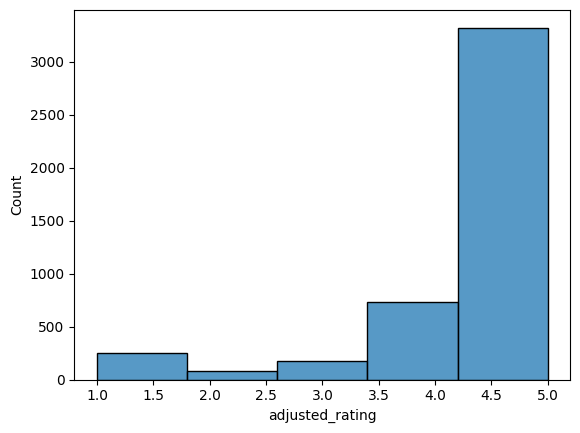

In [15]:
# Visualize distribution of adjusted ratings.
sns.histplot(df.adjusted_rating, bins=5)

<font color='violet'> Compare ratings across psychedelic drug types

In [16]:
# Create dictionary of drugs and the class they belong to. Import original list
drugs_file = open('../data/raw/erowid/psychedelic_drugs.txt', 'r')
drugs_as_string = drugs_file.read()
psychedelic_drugs = drugs_as_string.split(',')
psychedelic_drugs

['AET',
 'AL-LAD',
 'ALD-52',
 'ALEPH',
 'Aleph-4',
 'Allylescaline',
 'AMT',
 'Arylcyclohexylamines',
 'Ayahuasca',
 'Banisteriopsis caapi',
 'BOD',
 'BOH-2C-B',
 'Bufotenin',
 'Cacti - Mescaline-containing',
 'DALT',
 'Deschloroketamine',
 'DET',
 'DiPT',
 'DMT',
 'DMT-Containing',
 'DMXE',
 'DOB',
 'DOC',
 'DOET',
 'DOF',
 'DOI',
 'DOIP',
 'DOM',
 'DON',
 'DOPR',
 'DPT',
 'EIPLA',
 'EPT',
 'Escaline',
 'ETH-LAD',
 'Fluorexetamine',
 'H.B. Woodrose',
 'Harmaline',
 'Harmine',
 'Herbal Ecstasy',
 'HOT-17',
 'HOT-2',
 'HOT-7',
 'Huasca Brew',
 'Huasca Brew Group',
 'Huasca Combo',
 'Huasca Group',
 'HXE',
 'Iboga Alkaloid Group',
 'Ibogaine',
 'Isoproscaline',
 'Ketamine',
 'LSA',
 'LSD',
 'LSM-775',
 'LSZ',
 'MALT',
 'MDA',
 'MDAI',
 'MDE',
 'MDMA',
 'MEM',
 'Mescaline',
 'MET',
 'Methallylescaline',
 'Methoxetamine',
 'Methoxpropamine',
 'Mimosa ophthalmocentra',
 'Mimosa spp.',
 'Mimosa tenuiflora',
 'MIPLA',
 'MIPT',
 'MMDA',
 'MMDA-3a',
 'MPT',
 'Mushrooms',
 'Mushrooms - G. spect

In [17]:
drug_class_dict = {'AET':'tryptamine', 'AL-LAD':'tryptamine', 'ALD-52':'tryptamine',
                   'ALEPH':'phenethylamine', 'Aleph-4':'phenethylamine',
                   'Allylescaline':'phenethylamine', 'AMT':'tryptamine',
                   'Arylcyclohexylamines':'arylcyclohexylamine', 'Ayahuasca':'tryptamine',
                   'Banisteriopsis caapi':'other entheogen', 'BOD':'phenethylamine', 
                   'BOH-2C-B':'phenethylamine', 'Bufotenin':'tryptamine',
                   'Cacti - Mescaline-containing':'phenethylamine', 'DALT':'tryptamine',
                   'Deschloroketamine':'arylcyclohexylamine', 'DET':'tryptamine',
                   'DiPT':'tryptamine', 'DMT':'tryptamine', 'DMT-Containing':'tryptamine',
                   'DMXE':'arylcyclohexylamine', 'DOB':'phenethylamine', 
                   'DOC':'phenethylamine', 'DOET':'phenethylamine', 'DOF':'phenethylamine',
                   'DOI':'phenethylamine', 'DOIP':'phenethylamine', 'DOM':'phenethylamine',
                   'DON':'phenethylamine', 'DOPR':'phenethylamine', 'DPT':'tryptamine',
                   'EIPLA':'tryptamine', 'EPT':'tryptamine', 'Escaline':'phenethylamine',
                   'ETH-LAD':'tryptamine', 'Fluorexetamine':'arylcyclohexylamine',
                   'H.B. Woodrose':'other entheogen', 'Harmaline':'other entheogen',
                   'Harmine':'other entheogen', 'Herbal Ecstasy':'other entheogen',
                   'HOT-17':'phenethylamine', 'HOT-2':'phenethylamine', 
                   'HOT-7':'phenethylamine', 'Huasca Brew':'tryptamine', 
                   'Huasca Brew Group':'tryptamine', 'Huasca Combo':'tryptamine',
                   'Huasca Group':'tryptamine', 'HXE':'arylcyclohexylamine',
                   'Iboga Alkaloid Group':'other entheogen', 'Ibogaine':'other entheogen',
                   'Isoproscaline':'phenethylamine', 'Ketamine':'arylcyclohexylamine',
                   'LSA':'tryptamine', 'LSD':'tryptamine', 'LSM-775':'tryptamine',
                   'LSZ':'tryptamine', 'MALT':'tryptamine', 'MDA':'phenethylamine', 
                   'MDAI':'phenethylamine', 'MDE':'phenethylamine', 'MDMA':'phenethylamine', 
                   'MEM':'phenethylamine', 'Mescaline':'phenethylamine', 'MET':'tryptamine',
                   'Methallylescaline':'phenethylamine', 
                   'Methoxetamine':'arylcyclohexylamine',
                   'Methoxpropamine':'arylcyclohexylamine', 
                   'Mimosa ophthalmocentra':'other entheogen', 
                   'Mimosa spp.':'other entheogen', 
                   'Mimosa tenuiflora':'other entheogen', 'MIPLA':'tryptamine', 
                   'MIPT':'tryptamine', 'MMDA':'phenethylamine', 'MMDA-3a':'phenethylamine', 
                   'MPT':'tryptamine', 'Mushrooms':'tryptamine', 
                   'Mushrooms - G. spectabilis':'tryptamine', 
                   'Mushrooms - P. atlantis':'tryptamine', 
                   'Mushrooms - P. azurescens':'tryptamine', 
                   'Mushrooms - P. cubensis':'tryptamine', 
                   'Mushrooms - P. cyanescens':'tryptamine', 
                   'Mushrooms - P. mexicana':'tryptamine', 
                   'Mushrooms - P. semilanceata':'tryptamine', 
                   'Mushrooms - P. subaeruginosa':'tryptamine', 
                   'Mushrooms - P. tampanensis':"tryptamine",
                   'Mushrooms - P. weilii':'tryptamine',
                   'Mushrooms - Panaeolus cyanescens':'tryptamine', 
                   'MXiPr':'arylcyclohexylamine', 'PCE':'arylcyclohexylamine', 
                   'PCP':'arylcyclohexylamine', 'Peyote':'other entheogen', 
                   'Phenethylamine':'phenethylamine', 'Phenethylamines':'phenethylamine', 
                   'Phenethylamines - Other':'phenethylamine', 'PIPT':'tryptamine', 
                   'Proscaline':'phenethylamine', 'Psilocin':'tryptamine', 
                   'Psilocybin':'tryptamine', 'S-Ketamine':'arylcyclohexylamine', 
                   'Tabernanthe iboga':'other entheogen', 'TCB-2':'phenethylamine', 
                   'Tetrahydroharmine':'other entheogen', 'TMA':'phenethylamine', 
                   'TMA-2':'phenethylamine', 'TMA-6':'phenethylamine', 
                   'Tryptamines - Substituted':'tryptamine', '1B-LSD':'tryptamine', 
                   '1cP-AL-LAD':'tryptamine', '1cP-LSD':'tryptamine', '1F-LSD':'tryptamine', 
                   '1P-ETH-LAD':'tryptamine', '1P-LSD':'tryptamine', '1V-LSD':'tryptamine', 
                   "2'-Oxo-PCE":'arylcyclohexylamine', 
                   '2-Fluorodeschloroketamine':'arylcyclohexylamine', '2-Me-DMT':'tryptamine', 
                   '2C-B':'phenethylamine', '2C-B-Fly':'phenethylamine', 
                   '2C-C':'phenethylamine', '2C-CN':'phenethylamine', '2C-D':'phenethylamine', 
                   '2C-E':'phenethylamine', '2C-EF':'phenethylamine', 
                   '2C-G-N':'phenethylamine', '2C-H':'phenethylamine', 
                   '2C-I':'phenethylamine', 
                   '2C-IP':'phenethylamine', '2C-N':'phenethylamine', '2C-P':'phenethylamine',
                   '2C-T':'phenethylamine', '2C-T-13':'phenethylamine',
                   '2C-T-2':'phenethylamine', '2C-T-21':'phenethylamine', 
                   '2C-T-4':'phenethylamine', '2C-T-7':'phenethylamine', 
                   '2C-TFM':'phenethylamine', '4-MD-PCP':'arylcyclohexylamine', 
                   '3-Cl-PCP':'arylcyclohexylamine', '3-HO-PCE':'arylcyclohexylamine', 
                   '3-HO-PCP':'arylcyclohexylamine', '3-Me-PCE':'arylcyclohexylamine', 
                   '3-Me-PCPy':'arylcyclohexylamine', '3-MEO-PCE':'arylcyclohexylamine', 
                   '3-MeO-PCMo':'arylcyclohexylamine', '3-MeO-PCP':'arylcyclohexylamine', 
                   '3-Methyl-PCP':'arylcyclohexylamine', '3C-E':'phenethylamine', 
                   '3C-P':'phenethylamine', '3F-PCP':'phenethylamine', 
                   '4-AcO-DALT':'tryptamine', '4-AcO-DET':'tryptamine', 
                   '4-AcO-DiPT':'tryptamine', '4-AcO-DMT':'tryptamine', 
                   '4-AcO-DPT':'tryptamine', '4-AcO-EIPT':'tryptamine', 
                   '4-AcO-EPT':'tryptamine', '4-AcO-MALT':'tryptamine', 
                   '4-AcO-MET':'tryptamine', '4-AcO-MiPT':'tryptamine', 
                   '4-AcO-MPT':'tryptamine', '4-HO-DET':'tryptamine', 
                   '4-HO-DiPT':'tryptamine', 
                   '4-HO-DPT':'tryptamine', '4-HO-EPT':'tryptamine', 
                   '4-HO-MALT':'tryptamine', 
                   '4-HO-MCPT':'tryptamine', '4-HO-MET':'tryptamine', 
                   '4-HO-MiPT':'tryptamine', 
                   '4-HO-MPT':'tryptamine', '4-HO-PIPT':'tryptamine', 
                   '4-MeO-DMT':'tryptamine', 
                   '4-MeO-MiPT':'tryptamine', '4-MeO-PCP':'arylcyclohexylamine', 
                   '4-MTA':'phenethylamine', '4-PrO-DMT':'tryptamine', 
                   '4C-D':'phenethylamine', 
                   '5-Chloro-AMT':'tryptamine', '5-MeO-AET':'tryptamine', 
                   '5-MeO-AMT':'tryptamine', '5-MeO-DALT':'tryptamine', 
                   '5-MeO-DET':'tryptamine', '5-MeO-DiPT':'tryptamine', 
                   '5-MeO-DMT':'tryptamine', '5-MeO-DPT':'tryptamine', 
                   '5-MeO-EIPT':'tryptamine', '5-MeO-MALT':'tryptamine', 
                   '5-MeO-MET':'tryptamine', '5-MeO-MIPT':'tryptamine', 
                   '5-MeO-PIPT':'tryptamine', '5-MeO-TMT':'tryptamine',
                   '5-Methoxy-Tryptamine':'tryptamine'}

In [18]:
df['drug_class'] = [drug_class_dict[df.loc[row,'drug']] for row in range(len(df))]
df.head()

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10,rating,adjusted_rating,drug_class
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947,0.892374,5,5.0,tryptamine
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718,0.970629,5,3.0,tryptamine
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329,0.964469,5,5.0,tryptamine
3,AET,2007,Not Given,i read about people insuffulating this to bri...,5.6,read people insuffulate bring quick burn eye...,0.532292,0.207292,1079,0.911463,5,5.0,tryptamine
4,AET,1986,Not Given,back in the mid to late 80s aet was legal and...,6.9,mid late 80 aet legal available usual chemic...,0.447603,0.140524,1698,0.956280,5,5.0,tryptamine


In [19]:
# Is there much difference among the drug class ratings?
avg_rating_by_class = df.groupby('drug_class')['adjusted_rating'].mean()
avg_rating_by_class

drug_class
arylcyclohexylamine    4.382096
other entheogen        4.492647
phenethylamine         4.546456
tryptamine             4.472136
Name: adjusted_rating, dtype: float64

Differences in ratings across drug classes are minimal, and average ratings are higher than for prescription drugs from the original study (average rating there was approximately 3.9, still high but lower than this).

Because the original data was skewed toward perfect ratings, I assume my model might over-assigns perfect ratings, and this may be even more so the case when features don't line up exactly as with words this unseen data's vector. A more sensitive model with improved feature engineering might result in a wider range of ratings being predicted for various experience reports. It could also be the case that people are, in general, describing their experiences with psychedelic drugs more favorably than people described their experiences with prescription meds. 

For now, dig in further to this data, and do more to compare with the original studies. 

<font color='violet'> Visualize relationships across multiple variables & datasets

In [20]:
psychedelic_df = df
studies_df = pd.read_csv('../data/processed/studies_w_vector_similarity.csv').drop(
    columns=['Unnamed: 0'])
studies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31557 entries, 0 to 31556
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   condition          31557 non-null  object 
 1   date               31557 non-null  object 
 2   drug0              31557 non-null  object 
 3   drug1              31557 non-null  object 
 4   review_len         31557 non-null  int64  
 5   complexity         31557 non-null  float64
 6   no_stop_cap_lemm   31557 non-null  object 
 7   subjectivity       31557 non-null  float64
 8   original_polarity  31557 non-null  float64
 9   set                31557 non-null  object 
 10  rating             31557 non-null  float64
 11  similarity_w_10    31557 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 2.9+ MB


In [21]:
# Turn studies' ratings into 1-5 scale for simpler comparison with psychedelic ratings
studies_df['adjusted_rating'] = studies_df.rating.replace({2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4, 
                                                          9:5, 10:5}).astype(int)
studies_df.head()

,condition,date,drug0,drug1,review_len,complexity,no_stop_cap_lemm,subjectivity,original_polarity,set,rating,similarity_w_10,adjusted_rating
0,anxiety,2013-12-14,escitalopram,lexapro,36,-1.2,good give run gas,0.600000,0.700000,train,9.0,0.640050,5
1,anxiety,2017-03-13,pregabalin,na,547,5.4,75 mg x daily no noticeable effect 150 mg x da...,0.343056,0.031439,train,8.0,0.841263,4
2,depression,2016-10-16,mirtazapine,na,390,4.8,take 145 mg 10 year fantastic insomnia really ...,0.591667,0.096296,train,8.0,0.922576,4
3,bpd,2017-08-16,quetiapine,na,156,8.2,help stability mood help insomnia start experi...,1.000000,-1.000000,train,7.0,0.825203,4
4,depression,2014-09-19,fluoxetine,prozac,66,-0.4,crazy eat sleep sit,0.900000,-0.600000,train,2.0,0.467668,1


In [22]:
# Which drugs were most commonly written about in each dataset? 
study_drug_counter = Counter(studies_df.drug0)
study_counter_sorted = study_drug_counter.most_common()
study_freq_drugs = study_counter_sorted[:10]
study_freq_drugs

[('sertraline', 1855),
 ('escitalopram', 1711),
 ('citalopram', 1295),
 ('bupropion', 1277),
 ('venlafaxine', 1210),
 ('varenicline', 1081),
 ('quetiapine', 1061),
 ('clonazepam', 999),
 ('fluoxetine', 947),
 ('alprazolam', 882)]

In [23]:
psychedelic_drug_counter = Counter(psychedelic_df.drug)
psychedelic_counter_sorted = psychedelic_drug_counter.most_common()
psychedelic_freq_drugs = psychedelic_counter_sorted[:10]
psychedelic_freq_drugs

[('MDMA', 223),
 ('LSD', 151),
 ('DMT', 140),
 ('Mimosa tenuiflora', 121),
 ('2C-I', 114),
 ('4-AcO-DMT', 108),
 ('2C-E', 104),
 ('Mushrooms', 101),
 ('H.B. Woodrose', 100),
 ('Mushrooms - P. cubensis', 97)]

In [24]:
psychedelic_class_counter = Counter(psychedelic_df.drug_class)
class_counter_sorted = psychedelic_class_counter.most_common()
psychedelic_freq_class = class_counter_sorted[:10]
psychedelic_freq_class

[('tryptamine', 2243),
 ('phenethylamine', 1453),
 ('arylcyclohexylamine', 458),
 ('other entheogen', 408)]

In [25]:
# When were the different reviews/reports submitted? Start by cleaning up date column.
set(psychedelic_df.year)

{'1962',
 '1963',
 '1964',
 '1967',
 '1968',
 '1969',
 '1970',
 '1972',
 '1973',
 '1975',
 '1979',
 '1980',
 '1981-2007',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2001 2008',
 '2002',
 '2003',
 '2003-2004',
 '2004',
 '2005',
 '2005-2007',
 '2006',
 '2006-2007',
 '2006-2019',
 '2007',
 '2008',
 '2009',
 '2009-2010',
 '2010',
 '2011',
 '2011-2013',
 '2011-2018',
 '2012',
 '2012-2013',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2018-2019',
 '2019',
 '2020',
 '2020-2021',
 '2021',
 '2021-2022',
 '2022',
 '2023',
 'Exp Year:'}

In [26]:
psychedelic_df['year'] = psychedelic_df.year.replace({'1981-2007':'1981', '2001 2008':'2001',
                                                     '2003-2004':'2003', '2005-2007':'2005',
                                                     '2006-2007':'2006', '2006-2019':'2006',
                                                     '2009-2010':'2009', '2011-2013':'2011',
                                                     '2011-2018':'2011', '2012-2013':'2012',
                                                     '2018-2019':'2018', '2020-2021':'2020',
                                                     '2021-2022':'2021', 'Exp Year:':''})

psychedelic_df['year'] = psychedelic_df['year'].astype(int, errors='ignore')
psychedelic_df.year[:3]

0    2022
1    2006
2    2007
Name: year, dtype: object

In [27]:
studies_df['year'] = pd.to_datetime(studies_df.date)
studies_df['year'] = [studies_df.loc[row,'year'].year for row in range(len(studies_df))]
studies_df.year[:3]

0    2013
1    2017
2    2016
Name: year, dtype: int64

In [28]:
# Find how many reviews/reports were submitted each year
psychedelic_year_count = psychedelic_df.groupby('year')['adjusted_rating'].count().sort_values(
    ascending=False).drop(index='')

psychedelic_year_count.index = psychedelic_year_count.index.astype(int)
psychedelic_year_count

year
2003    332
2004    306
2012    267
2011    242
2005    241
2007    234
2010    233
2006    223
2014    215
2002    214
2016    203
2001    202
2008    185
2013    183
2017    170
2009    146
2018    145
2015    144
2020    132
2000    126
2021    123
2022    102
2019     98
1999     27
1998     14
1970      5
1995      4
1992      4
1997      4
2023      3
1993      3
1989      3
1975      3
1994      2
1986      2
1985      2
1968      2
1969      2
1979      2
1962      1
1973      1
1963      1
1964      1
1967      1
1972      1
1981      1
1980      1
1996      1
1984      1
1987      1
1988      1
1990      1
Name: adjusted_rating, dtype: int64

In [29]:
studies_year_count = studies_df.groupby('year')['adjusted_rating'].count().sort_values(
    ascending=False)

studies_year_count

year
2016    6610
2015    5202
2017    4998
2014    2631
2013    2599
2009    2378
2011    2297
2012    2080
2010    1646
2008    1116
Name: adjusted_rating, dtype: int64

<AxesSubplot: xlabel='year', ylabel='adjusted_rating'>

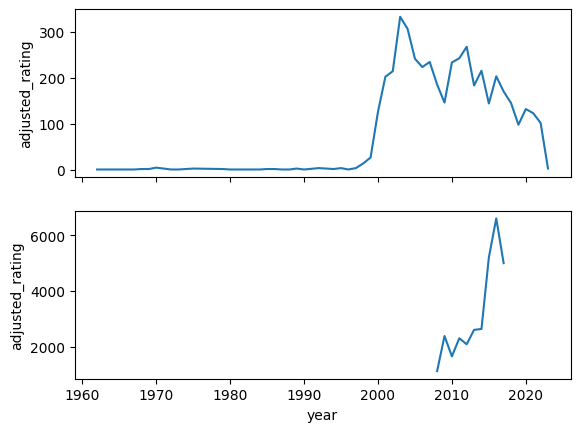

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
sns.lineplot(data=psychedelic_year_count, ax=axes[0])
sns.lineplot(data=studies_year_count, ax=axes[1])

[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Prescription Med Review Counts')]

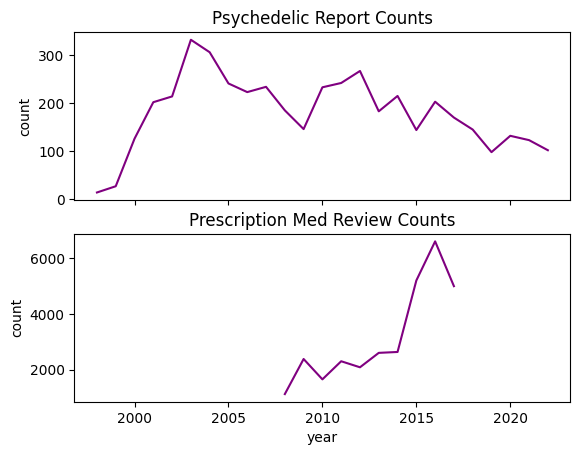

In [31]:
# Zoom in a bit
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
sns.lineplot(data=psychedelic_year_count.iloc[:25], ax=axes[0], color='purple').set(
    ylabel='count', title='Psychedelic Report Counts')
sns.lineplot(data=studies_year_count, ax=axes[1], color='purple').set(
    ylabel='count', title='Prescription Med Review Counts')

<AxesSubplot: xlabel='review_len', ylabel='Count'>

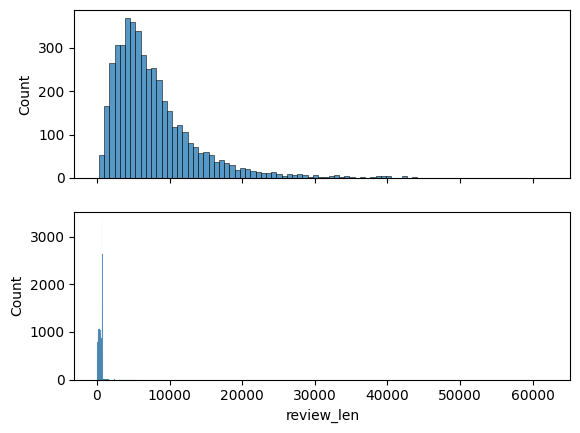

In [32]:
# How does the distribution of text lengths compare across the two datasets?
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
sns.histplot(data=psychedelic_df.review_len, ax=axes[0])
sns.histplot(data=studies_df.review_len, ax=axes[1])

[Text(0.5, 1.0, 'Prescription Med Review Length'),
 Text(0.5, 0, 'length in characters')]

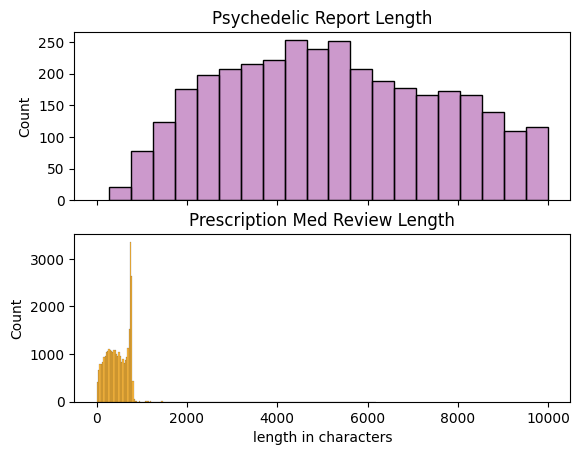

In [33]:
# Zoom in
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
sns.histplot(data=psychedelic_df[psychedelic_df.review_len<10000]['review_len'], 
             ax=axes[0], color='purple', alpha=0.4).set(title='Psychedelic Report Length')
sns.histplot(data=studies_df.review_len, ax=axes[1], color='orange').set(
    title='Prescription Med Review Length', xlabel='length in characters')

[Text(0.5, 1.0, 'Prescription Med Review Complexity'),
 Text(0.5, 0, 'text complexity in grade levels')]

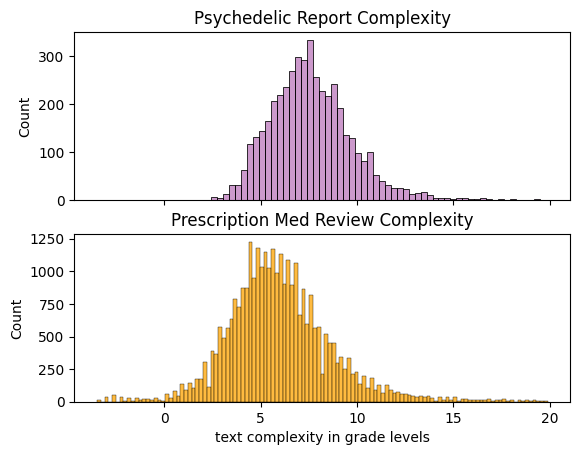

In [34]:
# How does text complexity compare across the two datasets?
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

sns.histplot(data=psychedelic_df[psychedelic_df.complexity<20]['complexity'], ax=axes[0],
             color='purple', alpha=0.4).set(title='Psychedelic Report Complexity')


sns.histplot(data=studies_df[studies_df.complexity<20]['complexity'], ax=axes[1], 
             color='orange').set(title='Prescription Med Review Complexity', 
                                 xlabel='text complexity in grade levels')

[Text(0.5, 1.0, 'Subjectivity Rating of Prescription Med Reviews')]

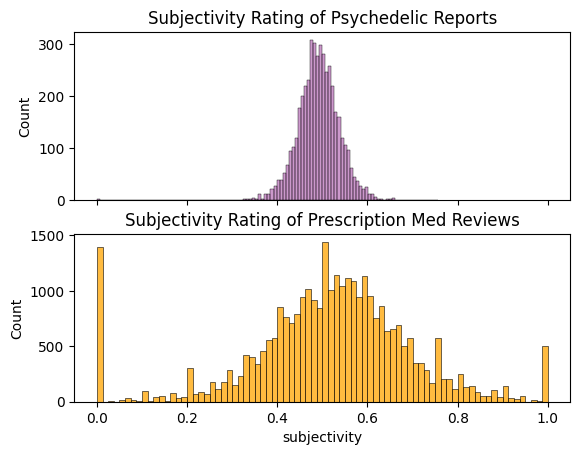

In [35]:
# Compare subjectivity and polarity across the datasets. 
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

sns.histplot(data=psychedelic_df.subjectivity, ax=axes[0], color='purple' ,alpha=0.4).set(
    title='Subjectivity Rating of Psychedelic Reports')

sns.histplot(data=studies_df.subjectivity, ax=axes[1], color='orange').set(
    title='Subjectivity Rating of Prescription Med Reviews')

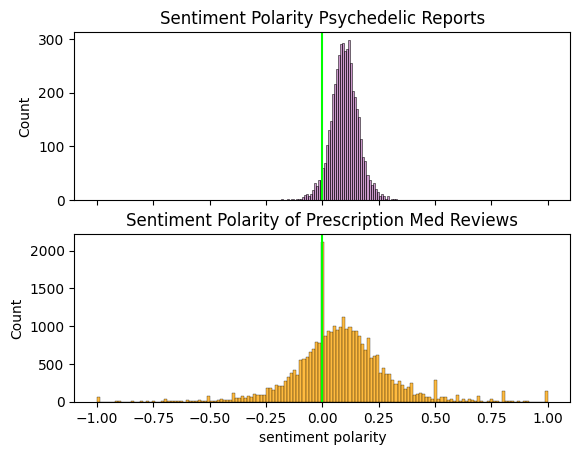

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

sns.histplot(data=psychedelic_df.polarity, ax=ax[0], color='purple', alpha=0.4).set(
    title='Sentiment Polarity Psychedelic Reports')

sns.histplot(data=studies_df.original_polarity, ax=ax[1], color='orange').set(
    title='Sentiment Polarity of Prescription Med Reviews', xlabel='sentiment polarity')

ax[0].axvline(x=0, color='lime')
ax[1].axvline(x=0, color='lime')

Polarity was the strongest predictor of ratings duringoriginal modeling. Here I can see that the sentiment polarity score of almost all psychedelic experience reports are positive. The difference is not extreme, but a higher percentage of the psych med reviews have a negative sentiment polarity score. This could explain why psychedelic experience reports were rated so highly. 

In [37]:
# Compare most common words, bigrams, and trigrams. 
psychedelic_word_counter = Counter(word_tokenize(' '.join(
    psychedelic_df['no_stops_lemm'].tolist())))
psychedelic_common_words = dict(psychedelic_word_counter.most_common(20))
psychedelic_common_words

{'feel': 49051,
 'like': 31406,
 'time': 28286,
 'experience': 26666,
 'trip': 20704,
 'go': 17933,
 'take': 16019,
 'think': 15664,
 'come': 15370,
 'no': 14840,
 'start': 13946,
 'much': 13001,
 'hour': 13001,
 'know': 12770,
 'effect': 12722,
 'look': 12618,
 'try': 12350,
 'thing': 12153,
 'friend': 11839,
 'get': 11679}

In [38]:
studies_word_counter = Counter(word_tokenize(' '.join(
    studies_df['no_stop_cap_lemm'].tolist())))
studies_common_words = dict(studies_word_counter.most_common(20))
studies_common_words

{'take': 21115,
 'feel': 20449,
 'day': 18221,
 'anxiety': 15667,
 'year': 14866,
 '!': 14539,
 'work': 14019,
 'effect': 12913,
 'start': 11951,
 'sleep': 11820,
 'week': 11447,
 'mg': 10912,
 'help': 10654,
 'time': 10288,
 'month': 9924,
 'like': 9855,
 'depression': 9598,
 'go': 9570,
 'life': 9406,
 'meditation': 9252}

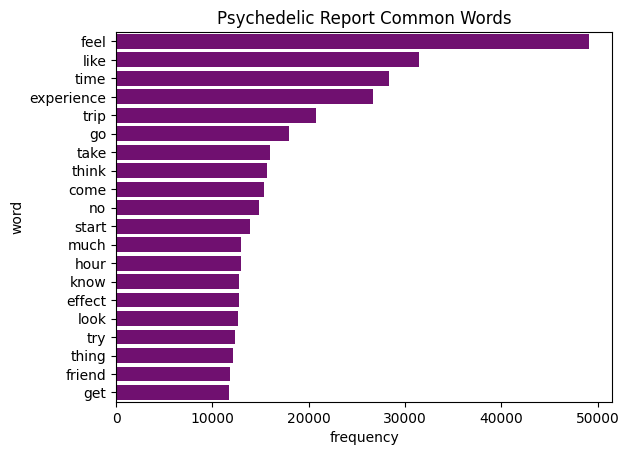

In [39]:
# Visualize each
psychedelic_common_words_df = pd.DataFrame(data = psychedelic_common_words.items(), 
                                     columns=['lemma', 'frequency'])
sns.barplot(data=psychedelic_common_words_df, x='frequency', y='lemma', color='purple').set(
    title='Psychedelic Report Common Words', ylabel='word')
plt.show()

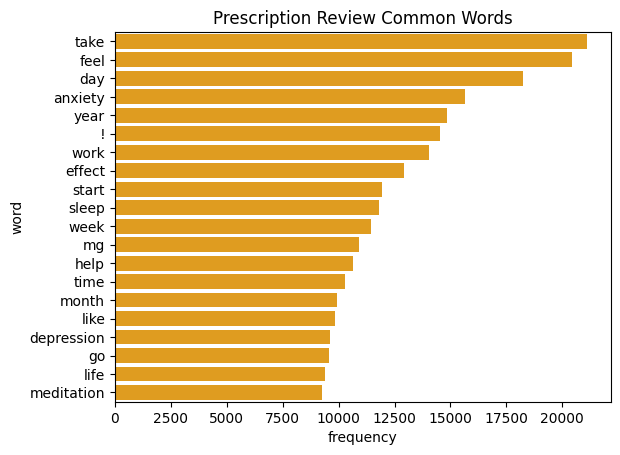

In [40]:
studies_common_words_df = pd.DataFrame(data = studies_common_words.items(), 
                                     columns=['lemma', 'frequency'])
sns.barplot(data=studies_common_words_df, x='frequency', y='lemma', color='orange').set(
    title='Prescription Review Common Words', ylabel='word')
plt.show()

In [41]:
# Which common words do these two have in common?
shared_common_words = set(studies_common_words_df.lemma).intersection(
    set(psychedelic_common_words_df.lemma))
shared_common_words

{'effect', 'feel', 'go', 'like', 'start', 'take', 'time'}

In [42]:
more_common_in_psychedelic = set(psychedelic_common_words_df.lemma) - shared_common_words
more_common_in_psychedelic

{'come',
 'experience',
 'friend',
 'get',
 'hour',
 'know',
 'look',
 'much',
 'no',
 'thing',
 'think',
 'trip',
 'try'}

In [43]:
more_common_in_studies = set(studies_common_words_df.lemma) - shared_common_words
more_common_in_studies

{'!',
 'anxiety',
 'day',
 'depression',
 'help',
 'life',
 'meditation',
 'mg',
 'month',
 'sleep',
 'week',
 'work',
 'year'}

In [47]:
# Explore bigrams. 

# Create function to get bigrams for each text
def get_bigram(text):
    bigram=''
    token = word_tokenize(text)
    bigram= list(ngrams(token, 2))
    return bigram   

# Generate bigrams into a column. Start with one df, then do the other
psychedelic_df['bigram'] = psychedelic_df['no_stops_lemm'].apply(get_bigram)

psychedelic_df.head(3)

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10,rating,adjusted_rating,drug_class,bigram
0,DMT,2022,22,seeing my buddhanature on dmt i am a 22 yea...,7.9,see buddhanature dmt 22 year old male 102 ...,0.386781,0.101679,5947,0.892374,5,5.0,tryptamine,"[(see, buddhanature), (buddhanature, dmt), (dm..."
1,AET,2006,Not Given,over the past week i have had the chance to t...,7.8,past week chance try aet 3 different dosage ...,0.485326,0.104717,9718,0.970629,5,3.0,tryptamine,"[(past, week), (week, chance), (chance, try), ..."
2,AET,2007,Not Given,800 pm\t130 mg aet oral capsule t+315\t\t1 ...,7.2,800 pm \t 130 mg aet oral capsule t+315 \...,0.536657,0.149442,11329,0.964469,5,5.0,tryptamine,"[(800, pm), (pm, 130), (130, mg), (mg, aet), (..."


In [49]:
type(psychedelic_df.loc[0,'bigram'])

list

In [50]:
# Get all bigrams together in one big list. 
all_psychedelic_bigrams = psychedelic_df.bigram.sum()
len(all_psychedelic_bigrams)

3009915

In [51]:
all_psychedelic_bigrams[:10]

[('see', 'buddhanature'),
 ('buddhanature', 'dmt'),
 ('dmt', '22'),
 ('22', 'year'),
 ('year', 'old'),
 ('old', 'male'),
 ('male', '102'),
 ('102', 'kg'),
 ('kg', 'tell'),
 ('tell', 'experience')]

In [54]:
# Count bigrams from psychedelic_df
psychedelic_bigram_counter = Counter(all_psychedelic_bigrams)
psychedelic_common_bigrams = dict(psychedelic_bigram_counter.most_common(23))
psychedelic_common_bigrams

{('feel', 'like'): 8688,
 ('close', 'eye'): 1912,
 ('+', '+'): 1897,
 ('first', 'time'): 1886,
 ('look', 'like'): 1684,
 ('start', 'feel'): 1529,
 ('!', '!'): 1332,
 ('fall', 'asleep'): 1208,
 ('no', 'long'): 1161,
 ('high', 'dose'): 1157,
 ('begin', 'feel'): 1114,
 ('t', '+'): 1049,
 ('open', 'eye'): 1030,
 ('body', 'load'): 1023,
 ('feel', 'good'): 1015,
 ('=', '='): 976,
 ('listen', 'music'): 971,
 ('little', 'bit'): 960,
 ('body', 'feel'): 925,
 ('half', 'hour'): 924,
 ('10', 'mg'): 912,
 ('long', 'time'): 874,
 ('20', 'mg'): 864}

In [53]:
# Repeat for studies
studies_df['bigram'] = studies_df['no_stop_cap_lemm'].apply(get_bigram)
all_studies_bigrams = studies_df.bigram.sum()
studies_bigram_counter = Counter(all_studies_bigrams)
studies_common_bigrams = dict(studies_bigram_counter.most_common(20))
studies_common_bigrams

{('feel', 'like'): 3830,
 ('panic', 'attack'): 3404,
 ('!', '!'): 2844,
 ('start', 'take'): 2105,
 ('weight', 'gain'): 1541,
 ('10', 'mg'): 1536,
 ('year', 'ago'): 1496,
 ('fall', 'asleep'): 1346,
 ('20', 'mg'): 1323,
 ('2', 'week'): 1299,
 ('stop', 'take'): 1179,
 ('much', 'well'): 1173,
 ('depression', 'anxiety'): 1168,
 ('year', 'old'): 1146,
 ('no', 'effect'): 1145,
 ('50', 'mg'): 1142,
 ('feel', 'well'): 1139,
 ('anxiety', 'depression'): 1082,
 ('first', 'week'): 973,
 ('work', 'great'): 963}

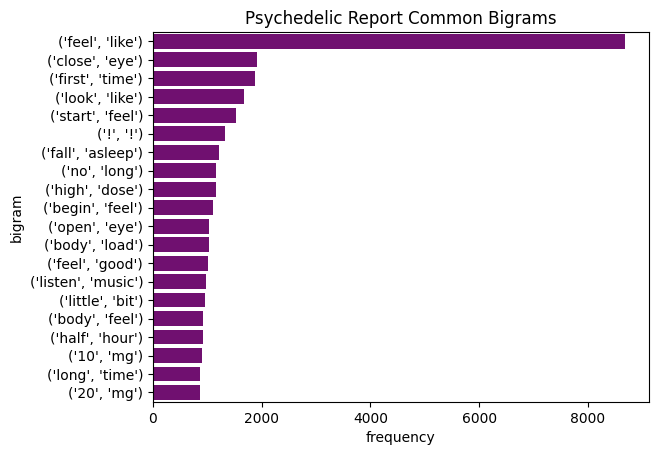

In [56]:
# Visualize
psychedelic_common_bigrams_df = pd.DataFrame(data = psychedelic_common_bigrams.items(), 
                                     columns=['bigram', 'frequency'])

# Some of the bigrams are some html/other nonsense I didn't catch before
psychedelic_common_bigrams_df = psychedelic_common_bigrams_df[~
    psychedelic_common_bigrams_df.bigram.isin([('+', '+'), ('t', '+'), ('=', '=')])]

# Now ready to plot top 20 bigrams
sns.barplot(data=psychedelic_common_bigrams_df, x='frequency', y='bigram', color='purple').set(
    title='Psychedelic Report Common Bigrams', ylabel='bigram')
plt.show()

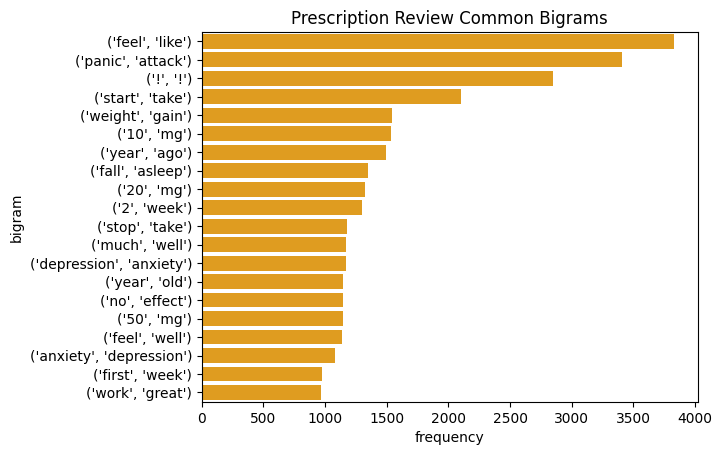

In [57]:
studies_common_bigrams_df = pd.DataFrame(data = studies_common_bigrams.items(), 
                                     columns=['bigram', 'frequency'])
sns.barplot(data=studies_common_bigrams_df, x='frequency', y='bigram', color='orange').set(
    title='Prescription Review Common Bigrams', ylabel='bigram')
plt.show()

In [61]:
# Which bigrams do they have in common?
shared_common_bigrams = set(studies_common_bigrams_df.bigram).intersection(
    set(psychedelic_common_bigrams_df.bigram))
shared_common_bigrams

{('!', '!'), ('10', 'mg'), ('20', 'mg'), ('fall', 'asleep'), ('feel', 'like')}

In [64]:
# Repeat with trigrams
def get_trigrams(text):
    trigram=''
    token = word_tokenize(text)
    trigram= list(ngrams(token, 3))
    return trigram   

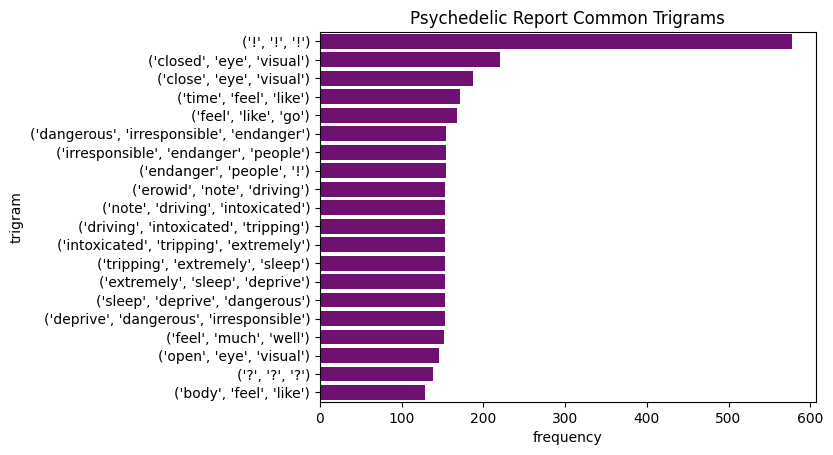

In [71]:
psychedelic_df['trigram'] = psychedelic_df['no_stops_lemm'].apply(get_trigrams)
all_psychedelic_trigrams = psychedelic_df.trigram.sum()
psychedelic_trigram_counter = Counter(all_psychedelic_trigrams)
psychedelic_common_trigrams = dict(psychedelic_trigram_counter.most_common(22))

psychedelic_common_trigrams_df = pd.DataFrame(data = psychedelic_common_trigrams.items(), 
                                     columns=['trigram', 'frequency'])

# Remove html/other junk again. 
# Many reports also have erowid's stock warning included. Don't drive intoxicated! Remove this.
psychedelic_common_trigrams_df = psychedelic_common_trigrams_df[~
    psychedelic_common_trigrams_df.trigram.isin([('+', '+', '+'), ('=', '=', '=')])]

# Plot psychedelic trigrams
sns.barplot(data=psychedelic_common_trigrams_df, x='frequency', y='trigram', 
            color='purple').set(title='Psychedelic Report Common Trigrams', ylabel='trigram')
plt.show()

Erowid includes in many of the texts a warning to people that they should not drive under the influence. It appears this is showing up a lot in the trigrams, and I don't want that. Find an example of this warning in the lemmatized text so I can try removing related trigrams and re-creating the chart. I don't want to remove something if it's a seemingly natural part of what somebody wrote, but I'm guessing the word "endnager" is usually showing up as part of the warning. 

In [82]:
psychedelic_df[psychedelic_df['no_stops_lemm'].str.find('endanger')!=-1].head(2)

,drug,year,age,report,complexity,no_stops_lemm,subjectivity,polarity,review_len,similarity_w_10,rating,adjusted_rating,drug_class,bigram,trigram,quadgram
8,AL-LAD,2017,35,an important experience in my life male 35 ...,5.0,important experience life male 35 year ol...,0.505030,0.094961,13421,0.935781,5,1.0,tryptamine,"[(important, experience), (experience, life), ...","[(important, experience, life), (experience, l...","[(important, experience, life, male), (experie..."
60,AL-LAD,2014,31,background of the day it was friday and i had...,8.1,background day friday miss lot sleep sleep...,0.490978,0.050508,12418,0.942212,5,5.0,tryptamine,"[(background, day), (day, friday), (friday, mi...","[(background, day, friday), (day, friday, miss...","[(background, day, friday, miss), (day, friday..."


In [83]:
psychedelic_df.no_stops_lemm[60]

'  background day friday miss lot sleep   sleep approximately 34 hour night few day lead sleep night   take drug possibly attribute alcohol withdrawal   initially have second thought cancel plan decide science plenty leave research way   sleep dep reasonably drain importantly poorly affect trip agitated shaky   measure blood pressure elevate pulse 150 systolic blood pressure pulse 105   undermine 120 systolic 78 pulse     intro 2 pm   friend drive inform lousy condition tell first thing first pick multivitamin go emergenc shake alcohol straighten    3 pm drink 23rd 40 steel reserve 211 cup emergenc   steel reserve disgusting note no long drink regardless economy   measure vital slightly improve 147149 systolic pulse 9799    430 pm drive regional park lake hike trail    445 pm drop 150 ug sit wooden table rest area park designate bbqs      000 455   5 pm swallow tab finish leftover 40   hold tongue friend hold   mention report allad orally active lsd claim orally active hold hour nothin

The text I'm looking to remove looks like this: 
erowid note driving intoxicated tripping extremely sleep deprive dangerous irresponsible endanger people !

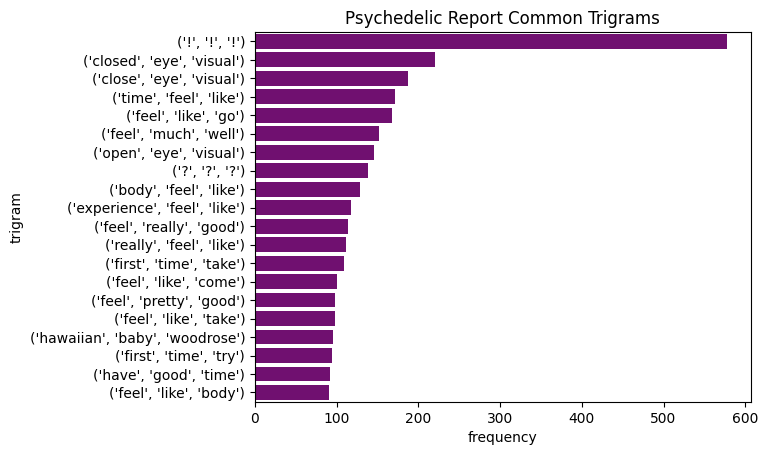

In [89]:
# Some more junk popped up also upon extending the most_common trigrams list
trigrams_to_remove = [('erowid', 'note', 'driving'), ('note', 'driving', 'intoxicated'), 
                      ('driving', 'intoxicated', 'tripping'), 
                      ('intoxicated', 'tripping', 'extremely'), 
                      ('tripping', 'extremely', 'sleep'), 
                      ('extremely', 'sleep', 'deprive'), ('sleep', 'deprive', 'dangerous'), 
                      ('deprive', 'dangerous', 'irresponsible'), 
                      ('dangerous', 'irresponsible', 'endanger'), 
                      ('irresponsible', 'endanger', 'people'), 
                      ('endanger', 'people', '!'), ('+', '+', '+'), ('=', '=', '='), 
                      ('+', '+', ')'), ('(', '+', '+')]

# Now try again
psychedelic_df['trigram'] = psychedelic_df['no_stops_lemm'].apply(get_trigrams)
all_psychedelic_trigrams = psychedelic_df.trigram.sum()
psychedelic_trigram_counter = Counter(all_psychedelic_trigrams)
psychedelic_common_trigrams = dict(psychedelic_trigram_counter.most_common(35))

psychedelic_common_trigrams_df = pd.DataFrame(data = psychedelic_common_trigrams.items(), 
                                     columns=['trigram', 'frequency'])

# Remove all html and stock warning trigrams.
psychedelic_common_trigrams_df = psychedelic_common_trigrams_df[~
    psychedelic_common_trigrams_df.trigram.isin(trigrams_to_remove)]

# Visualize
sns.barplot(data=psychedelic_common_trigrams_df, x='frequency', y='trigram', 
            color='purple').set(title='Psychedelic Report Common Trigrams', ylabel='trigram')
plt.show()

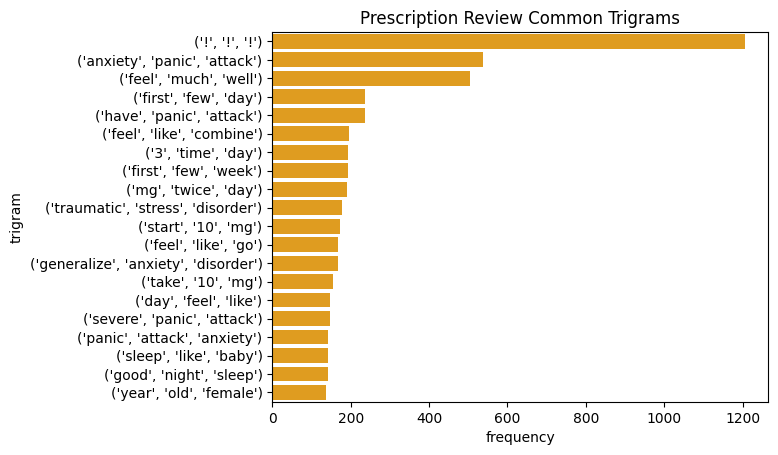

In [67]:
studies_df['trigram'] = studies_df['no_stop_cap_lemm'].apply(get_trigrams)
all_studies_trigrams = studies_df.trigram.sum()
studies_trigram_counter = Counter(all_studies_trigrams)
studies_common_trigrams = dict(studies_trigram_counter.most_common(20))

studies_common_trigrams_df = pd.DataFrame(data = studies_common_trigrams.items(), 
                                     columns=['trigram', 'frequency'])

sns.barplot(data=studies_common_trigrams_df, x='frequency', y='trigram', color='orange').set(
    title='Prescription Review Common Trigrams', ylabel='trigram')
plt.show()

In [90]:
# Which trigrams do they have in common?
shared_common_trigrams = set(studies_common_trigrams_df.trigram).intersection(
    set(psychedelic_common_trigrams_df.trigram))
shared_common_trigrams

{('!', '!', '!'), ('feel', 'like', 'go'), ('feel', 'much', 'well')}

In [86]:
# Confirm I have the correct summary statistics for each table
psychedelic_df.describe()

,complexity,subjectivity,polarity,review_len,similarity_w_10,rating,adjusted_rating
count,4562.000000,4562.000000,4562.000000,4562.000000,4562.000000,4562.000000,4562.000000
mean,7.710259,0.491670,0.098781,7965.742438,0.929463,4.999781,4.488601
std,3.330844,0.047045,0.062155,6329.388498,0.057538,0.014805,1.047010
min,1.500000,0.000000,-0.200000,276.000000,-0.032822,4.000000,1.000000
25%,6.200000,0.463563,0.060879,3972.750000,0.920831,5.000000,4.000000
50%,7.400000,0.491295,0.098216,6286.500000,0.936868,5.000000,5.000000
75%,8.800000,0.519891,0.136018,9949.000000,0.949564,5.000000,5.000000
max,146.800000,0.756250,0.600000,62080.000000,0.986370,5.000000,5.000000


In [87]:
studies_df.describe()

,review_len,complexity,subjectivity,original_polarity,rating,similarity_w_10,adjusted_rating,year
count,31557.000000,31557.000000,31557.000000,31557.000000,31557.000000,31557.000000,31557.000000,31557.000000
mean,473.539183,6.197731,0.515635,0.083930,7.425040,0.872306,3.928225,2013.828754
std,248.027128,3.769987,0.188783,0.216398,3.067076,0.089091,1.446717,2.718769
min,8.000000,-3.500000,0.000000,-1.000000,1.000000,-0.097608,1.000000,2008.000000
25%,269.000000,4.300000,0.425641,-0.025000,6.000000,0.848319,3.000000,2012.000000
50%,479.000000,5.800000,0.527143,0.075000,9.000000,0.899638,5.000000,2015.000000
75%,713.000000,7.400000,0.623333,0.191204,10.000000,0.929183,5.000000,2016.000000
max,6196.000000,62.500000,1.000000,1.000000,10.000000,0.984921,5.000000,2017.000000


I believe I'm ready to pull some of these findings into a document for summary documentation. 